In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

#import janestreet
#env = janestreet.make_env() # initialize the environment

#!pip install datatable # Internet is not activated in this competition
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl
import datatable as dt

import pickle
MODEL_FILE = '/kaggle/working/model_clustering.pickle'

#import xgboost as xgb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

INPUT_DIR = '/kaggle/input/jane-street-market-prediction/'

Processing /kaggle/input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl


/kaggle/input/jane-street-market-prediction/example_sample_submission.csv
/kaggle/input/jane-street-market-prediction/features.csv
/kaggle/input/jane-street-market-prediction/example_test.csv
/kaggle/input/jane-street-market-prediction/train.csv
/kaggle/input/jane-street-market-prediction/janestreet/__init__.py
/kaggle/input/jane-street-market-prediction/janestreet/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl


In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load data

In [3]:
%%time
# Thanks to his notebook for this fast loading : https://www.kaggle.com/carlmcbrideellis/jane-street-eda-of-day-0-and-feature-importance
train_data_datatable = dt.fread('../input/jane-street-market-prediction/train.csv')
df = train_data_datatable.to_pandas()

# Thanks to this notebook to gain memory usage : https://www.kaggle.com/jorijnsmit/one-liner-to-halve-your-memory-usage
float64_cols = df.select_dtypes(include='float64').columns
mapper = {col_name: np.float32 for col_name in float64_cols}
df = df.astype(mapper)

CPU times: user 44.3 s, sys: 14.4 s, total: 58.7 s
Wall time: 23.3 s


# Calculate target to predict

In [4]:
df['resp_positive'] = ((df['resp'])>0)*1

# Load features metadata

In [5]:
df_features = pd.read_csv('../input/jane-street-market-prediction/features.csv')

In [6]:
#df_features = df_features.set_index('feature')

In [7]:
df_features

,feature,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,...,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28
0,feature_0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,feature_1,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,feature_2,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,feature_3,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4,feature_4,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,feature_125,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
126,feature_126,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
127,feature_127,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
128,feature_128,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


# Clustering

In [8]:
FEATURES_LIST = ['tag_' + str(i) for i in range(29)]

In [9]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(df_features[FEATURES_LIST])
                for k in range(1, 50)]

In [10]:
silhouette_scores = [silhouette_score(df_features[FEATURES_LIST], model_clustering.labels_)
                     for model_clustering in kmeans_per_k[1:]]

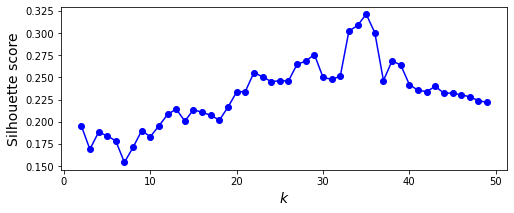

In [11]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 50), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
#plt.axis([1.8, 8.5, 0.55, 0.7]) # [xmin, xmax, ymin, ymax]
#save_fig("silhouette_score_vs_k_plot")
plt.show()

In [12]:
np.argmax(silhouette_scores)

33

In [13]:
silhouette_scores[np.argmax(silhouette_scores)]

0.3214544058255307

In [14]:
kmeans_per_30 = KMeans(n_clusters=np.argmax(silhouette_scores) + 2, random_state=42).fit(df_features[FEATURES_LIST])

In [15]:
silhouette_score_30 = silhouette_score(df_features[FEATURES_LIST], kmeans_per_30.labels_)
                     

In [16]:
silhouette_score_30

0.3214544058255307

In [17]:
cluster_vector = kmeans_per_30.predict(df_features[FEATURES_LIST])

In [18]:
cluster_vector

array([ 2, 10, 10, 24, 24, 28, 28, 31, 31, 23, 23, 27, 27, 19, 19, 14, 14,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4, 26, 26, 30, 30,  0,  0, 12,
       12, 21, 21,  4,  4, 12,  0, 17, 17, 17, 22, 22,  2,  2,  2,  2,  2,
        2,  2, 20, 20, 18, 18, 18, 18, 18, 29, 29, 25, 25,  8, 29, 29, 25,
       25, 20, 20, 20, 16, 16, 16, 16, 16, 16,  1,  1,  1,  1,  1,  1,  3,
        3,  3,  3,  3,  3, 15, 15, 15, 15, 15, 15,  5,  5,  5,  5,  5,  5,
       13, 13, 13, 13, 13, 13,  9,  9,  9,  9,  9,  9,  6,  6,  6,  6,  6,
        6,  7,  7, 11, 11, 34, 34, 33, 33, 32, 32], dtype=int32)

In [19]:
col_cluster_numbers = ['feature'+str(i)+'_cluster' for i in range(130)]

In [20]:
pd.DataFrame(cluster_vector).T

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,2,10,10,24,24,28,28,31,31,23,...,7,7,11,11,34,34,33,33,32,32


In [21]:
pd.DataFrame(pd.Series(cluster_vector, index=col_cluster_numbers)).T

,feature0_cluster,feature1_cluster,feature2_cluster,feature3_cluster,feature4_cluster,feature5_cluster,feature6_cluster,feature7_cluster,feature8_cluster,feature9_cluster,...,feature120_cluster,feature121_cluster,feature122_cluster,feature123_cluster,feature124_cluster,feature125_cluster,feature126_cluster,feature127_cluster,feature128_cluster,feature129_cluster
0,2,10,10,24,24,28,28,31,31,23,...,7,7,11,11,34,34,33,33,32,32


In [22]:
pd.get_dummies(pd.DataFrame(cluster_vector).T)

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
0,2,10,10,24,24,28,28,31,31,23,...,7,7,11,11,34,34,33,33,32,32
